CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1067
Rows that have all features = NaN: 21
TRAIN rows: 938
VAL   rows: 108
TEST  rows: 21
Current device: cuda

=== Running ARIMA Baseline Model with Recursive Test Predictions ===
[ARIMA] ARIMA baseline model created.


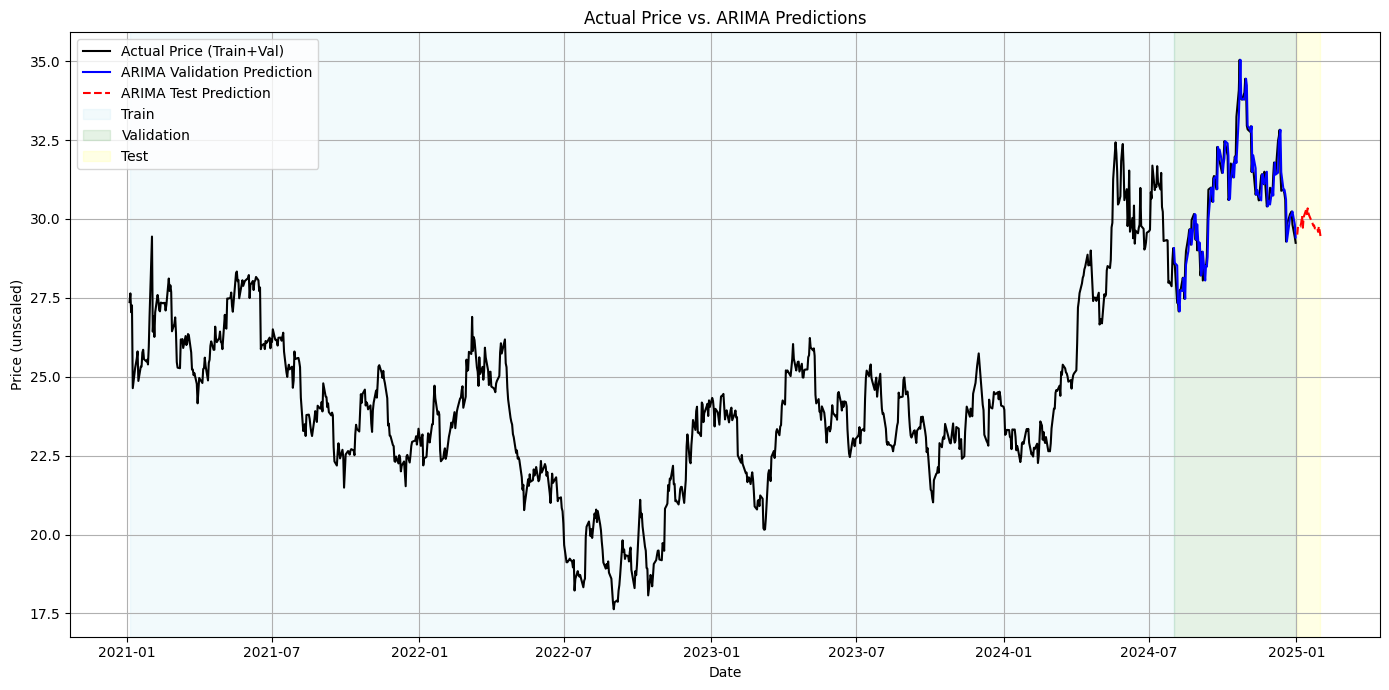

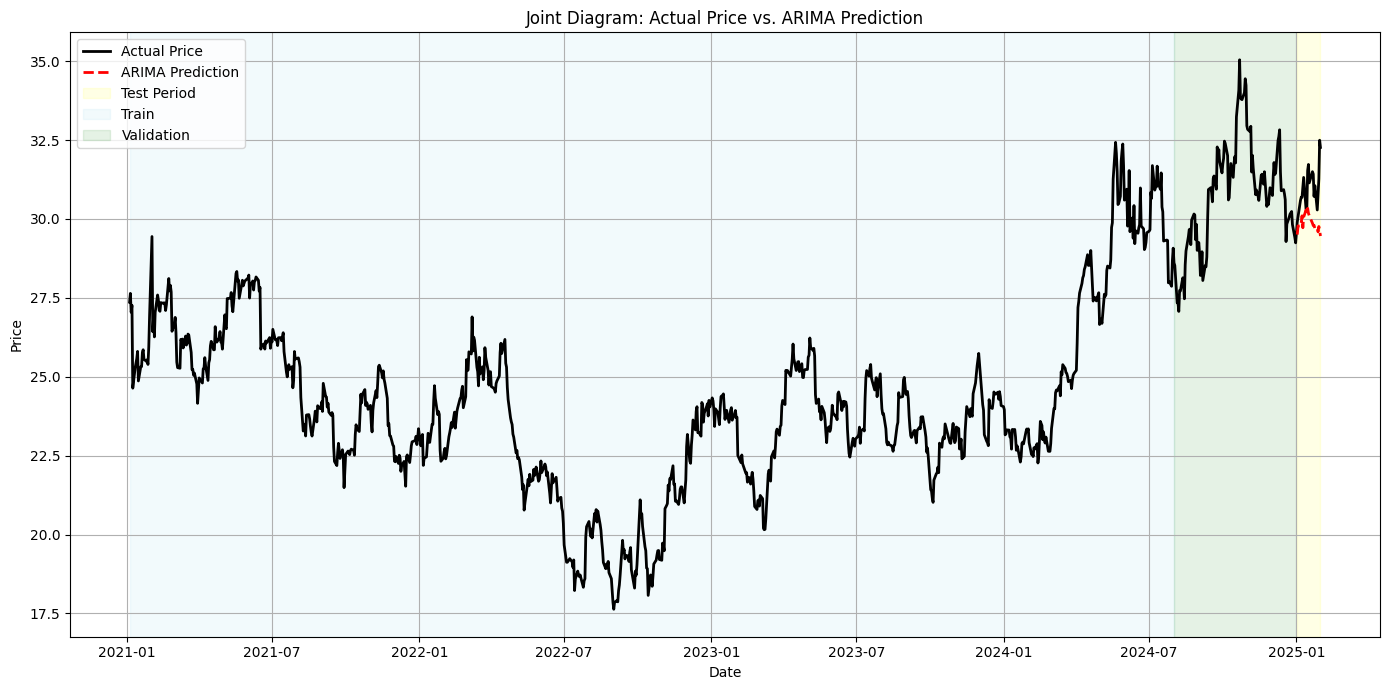

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib
from statsmodels.tsa.arima.model import ARIMA
import torch.backends.cudnn as cudnn

# Let CuDNN pick the fastest algorithm for your hardware
cudnn.benchmark = True

###############################################################################
# 1. Set random seeds
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 35
features = ["Price", "Open", "High", "Low"]
csv_file = "Silver Futures Historical Data.csv"

###############################################################################
# 2. Load & Clean CSV
###############################################################################
df = pd.read_csv(csv_file)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

###############################################################################
# 3. Date cutoffs: TRAIN, VAL, TEST
###############################################################################
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])
val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])
train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

###############################################################################
# 5. Create Training Sequences (for pipeline consistency)
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=len(train_dataset),  # single-batch approach
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4
)

###############################################################################
# 6. ARIMA Baseline Model Definition
###############################################################################
class ARIMAModel(nn.Module):
    def __init__(self, order=(1,0,0), epsilon=1e-4):
        """
        ARIMA baseline model.
        order: tuple, ARIMA order. Default (1,0,0) is an AR(1) model.
        epsilon: if the standard deviation of the input series is below this threshold,
                 the series is considered constant.
        """
        super().__init__()
        self.order = order
        self.epsilon = epsilon
        
    def forward(self, x):
        # x: tensor of shape (batch, window, features)
        batch_predictions = []
        for sample in x:
            sample_pred = []
            for feature in range(sample.shape[1]):
                series = sample[:, feature].detach().cpu().numpy()
                if np.std(series) < self.epsilon:
                    forecast = series[-1]
                else:
                    try:
                        model = ARIMA(series, order=self.order)
                        model_fit = model.fit(disp=0)
                        forecast = model_fit.forecast(steps=1)[0]
                    except Exception as e:
                        forecast = series[-1]
                sample_pred.append(forecast)
            batch_predictions.append(sample_pred)
        return torch.tensor(batch_predictions).float().to(x.device)

def train_model_arima():
    model = ARIMAModel(order=(1,0,0)).to(device)
    print("[ARIMA] ARIMA baseline model created.")
    return model

###############################################################################
# 7. Validation Predictions (Non-iterative)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy().sort_values("Date")
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 8. Iterative Walk-Forward Test Predictions with Recursive Updates and Noise
###############################################################################
def iterative_walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE, noise_std=0.01):
    """
    In testing, when actual observations are no longer available,
    use the model's predicted values (with added Gaussian noise)
    as inputs for the next prediction.
    """
    df_work = df_all_scaled.copy().sort_values("Date")
    test_idx = df_work.index[df_work["Date"] >= test_start]
    if len(test_idx) == 0:
        raise ValueError("No test data available after test_start")
    first_test_idx = test_idx[0]
    # Initialize current window using actual data
    current_window = df_work.iloc[first_test_idx - window:first_test_idx][features].values
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    preds = []
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            # Inject random Gaussian noise to introduce volatility
            noise = np.random.normal(scale=noise_std, size=pred_scaled.shape)
            pred_scaled_noisy = pred_scaled + noise
            preds.append((d, *pred_scaled_noisy))
            # Update window recursively using the predicted (noisy) values
            current_window = np.vstack((current_window[1:], pred_scaled_noisy))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 9. Evaluation & Plotting
###############################################################################
def evaluate_and_plot(val_pred_df, test_pred_df):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy().sort_values("Date")
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = scaler.inverse_transform(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    if val_pred_df is not None and not val_pred_df.empty:
        plt.plot(val_pred_df["Date"], val_pred_df["Pred_Price_unscaled"],
                 color="blue", linestyle="-", label="ARIMA Validation Prediction")
    
    if test_pred_df is not None and not test_pred_df.empty:
        plt.plot(test_pred_df["Date"], test_pred_df["Pred_Price_unscaled"],
                 color="red", linestyle="--", label="ARIMA Test Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, df_real["Date"].max(), color="yellow", alpha=0.1, label="Test")
    
    plt.title("Actual Price vs. ARIMA Predictions")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 10. MAIN
###############################################################################
if __name__ == "__main__":
    print("\n=== Running ARIMA Baseline Model with Recursive Test Predictions ===")
    model = train_model_arima()
    
    # Get validation predictions (using actual observations)
    val_pred_df = half_blind_validation_preds_df(
        model,
        df_scaled,
        val_start=train_cutoff,
        val_end=val_cutoff,
        window=WINDOW_SIZE
    )
    
    # Get iterative walk-forward test predictions (recursive, with Gaussian noise)
    test_pred_df = iterative_walk_forward_test(
        model,
        df_all_scaled=df_scaled,
        test_start=test_cutoff,
        window=WINDOW_SIZE,
        noise_std=0.01  # Adjust noise level as needed
    )
    
    evaluate_and_plot(val_pred_df, test_pred_df)
    
    # ================================
    # Additional Plot: Joint Diagram of Actual vs. ARIMA Test Predictions
    # ================================
    df_actual = pd.read_csv("Silver Futures Historical Data_Complete.csv")
    df_actual.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_actual['Date'] = pd.to_datetime(df_actual['Date'])
    df_actual.sort_values(by='Date', ascending=True, inplace=True)
    df_actual.reset_index(drop=True, inplace=True)
    
    # Clean numerical columns: remove commas and convert to float
    num_cols = df_actual.columns.drop("Date")
    df_actual[num_cols] = df_actual[num_cols].replace({',': ''}, regex=True)
    df_actual[num_cols] = df_actual[num_cols].astype('float64')
    
    actual_dates = df_actual['Date']
    actual_prices = df_actual['Price']
    
    plt.figure(figsize=(14, 7))
    plt.plot(actual_dates, actual_prices, color='black', linewidth=2, label='Actual Price')
    if test_pred_df is not None and not test_pred_df.empty:
        plt.plot(pd.to_datetime(test_pred_df["Date"]), test_pred_df["Pred_Price_unscaled"],
                 color="red", linestyle="--", linewidth=2, label='ARIMA Prediction')
    
    plt.axvspan(pd.to_datetime("2025-01-02"), actual_dates.iloc[-1], color='yellow', alpha=0.1, label='Test Period')
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    
    plt.title("Joint Diagram: Actual Price vs. ARIMA Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1067
Rows that have all features = NaN: 21
TRAIN rows: 938
VAL   rows: 108
TEST  rows: 21
Current device: cuda

=== Running ARIMA Baseline Model with Recursive Test Predictions ===
[ARIMA] ARIMA baseline model created.


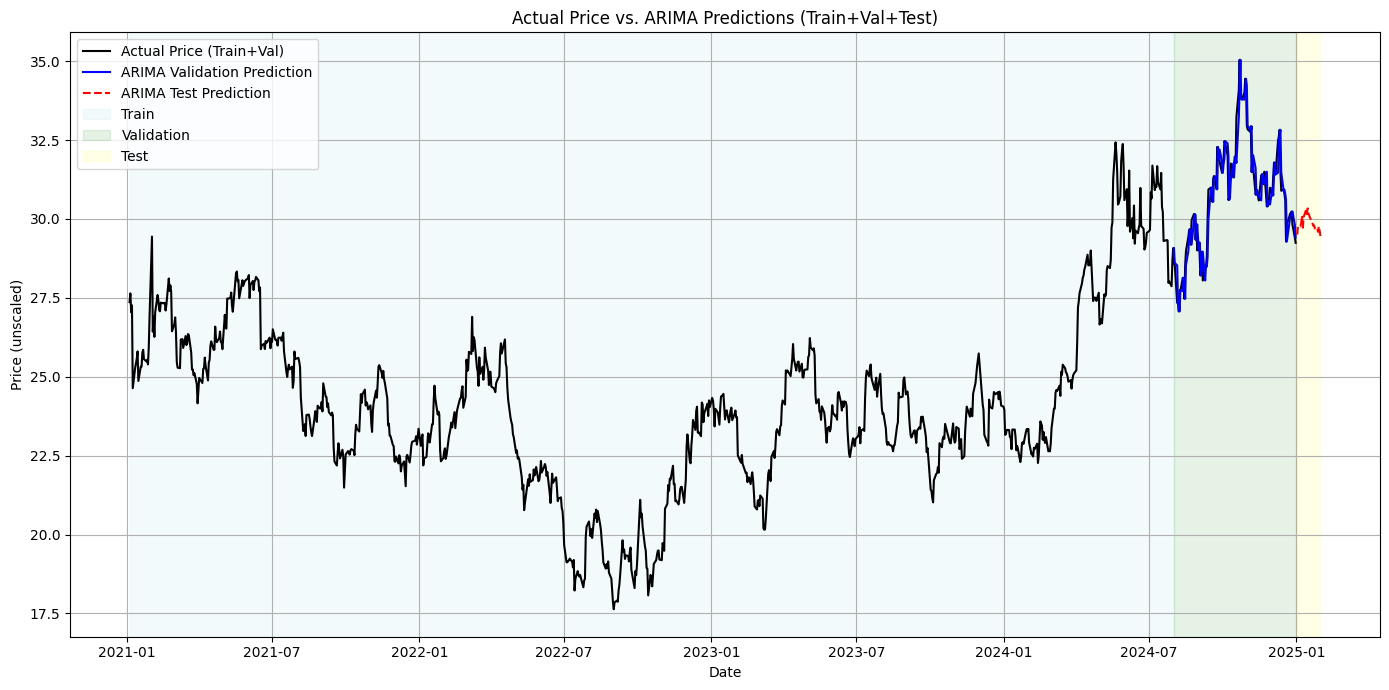

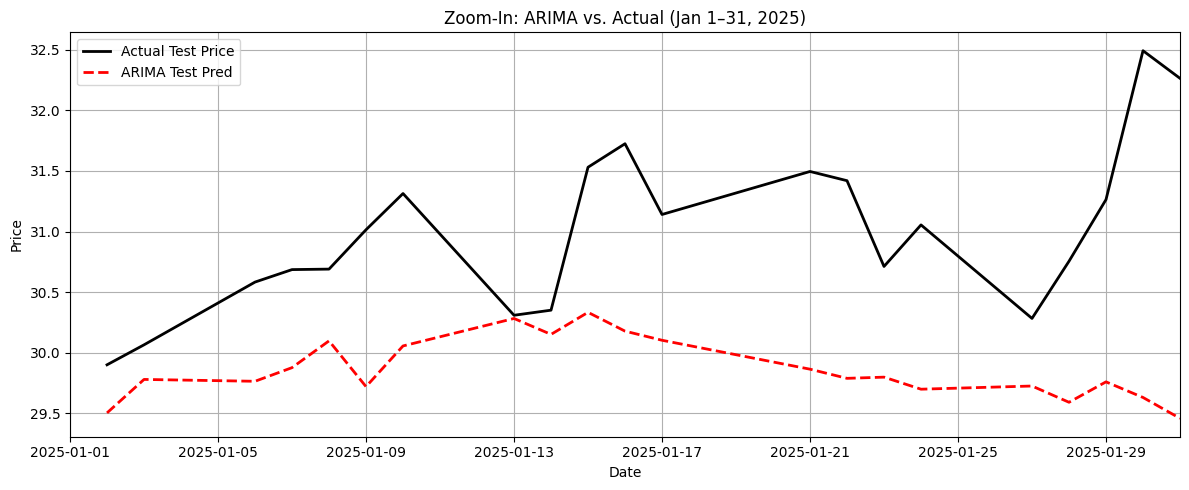

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib
from statsmodels.tsa.arima.model import ARIMA
import torch.backends.cudnn as cudnn

# Let CuDNN pick the fastest algorithm for your hardware
cudnn.benchmark = True

###############################################################################
# 1. Set random seeds
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 35
features = ["Price", "Open", "High", "Low"]
csv_file = "Silver Futures Historical Data.csv"

###############################################################################
# 2. Load & Clean CSV
###############################################################################
df = pd.read_csv(csv_file)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

###############################################################################
# 3. Date cutoffs: TRAIN, VAL, TEST
###############################################################################
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

###############################################################################
# 5. Create Training Sequences (for pipeline consistency)
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=len(train_dataset),  # single-batch approach
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4
)

###############################################################################
# 6. ARIMA Baseline Model Definition
###############################################################################
class ARIMAModel(nn.Module):
    def __init__(self, order=(1,0,0), epsilon=1e-4):
        """
        ARIMA baseline model (univariate per feature).
        order: ARIMA order, e.g., (1,0,0) is AR(1).
        epsilon: threshold below which std is near-constant => fallback last value.
        """
        super().__init__()
        self.order = order
        self.epsilon = epsilon
        
    def forward(self, x):
        # x: shape (batch, window, features)
        # We'll do an ARIMA fit for each feature in each sample.
        batch_predictions = []
        for sample in x:
            sample_pred = []
            for feature_idx in range(sample.shape[1]):
                series = sample[:, feature_idx].detach().cpu().numpy()
                # If nearly constant => just return the last value
                if np.std(series) < self.epsilon:
                    forecast = series[-1]
                else:
                    try:
                        model = ARIMA(series, order=self.order)
                        model_fit = model.fit(disp=0)
                        forecast = model_fit.forecast(steps=1)[0]
                    except Exception:
                        # fallback if ARIMA fails
                        forecast = series[-1]
                sample_pred.append(forecast)
            batch_predictions.append(sample_pred)

        return torch.tensor(batch_predictions).float().to(x.device)

def train_model_arima():
    model = ARIMAModel(order=(1,0,0)).to(device)
    print("[ARIMA] ARIMA baseline model created.")
    return model

###############################################################################
# 7. Validation Predictions (Non-iterative)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy().sort_values("Date")
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    
    # Inverse-scale
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 8. Iterative Walk-Forward Test Predictions with Recursive Updates + Noise
###############################################################################
def iterative_walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE, noise_std=0.01):
    """
    In testing, when actual observations are no longer available,
    use the model's predicted values (with added Gaussian noise)
    as inputs for the next prediction.
    """
    df_work = df_all_scaled.copy().sort_values("Date")
    test_idx = df_work.index[df_work["Date"] >= test_start]
    if len(test_idx) == 0:
        raise ValueError("No test data available after test_start")

    first_test_idx = test_idx[0]
    # Current window uses real data for the last 'window' rows before test_start
    current_window = df_work.iloc[first_test_idx - window:first_test_idx][features].values

    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    preds = []

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            # Add some random noise => prevents going fully flat
            noise = np.random.normal(scale=noise_std, size=pred_scaled.shape)
            pred_scaled_noisy = pred_scaled + noise

            preds.append((d, *pred_scaled_noisy))
            # Update window recursively using the predicted (noisy) values
            current_window = np.vstack((current_window[1:], pred_scaled_noisy))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    # Inverse-scale
    scl_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]

    return pred_df

###############################################################################
# 9A. Overall (Train+Val+Test) Plot
###############################################################################
def evaluate_and_plot(val_pred_df, test_pred_df):
    """
    Single figure showing train+val actual vs. predictions, plus test predictions.
    """
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy().sort_values("Date")
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = scaler.inverse_transform(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")

    if val_pred_df is not None and not val_pred_df.empty:
        plt.plot(val_pred_df["Date"], val_pred_df["Pred_Price_unscaled"],
                 color="blue", linestyle="-", label="ARIMA Validation Prediction")
    
    if test_pred_df is not None and not test_pred_df.empty:
        plt.plot(test_pred_df["Date"], test_pred_df["Pred_Price_unscaled"],
                 color="red", linestyle="--", label="ARIMA Test Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, df_real["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Actual Price vs. ARIMA Predictions (Train+Val+Test)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 9B. Test Period Zoom-In (Jan 1 to Jan 31, 2025)
###############################################################################
def plot_test_period_zoom(test_pred_df, df_complete_file="Silver Futures Historical Data_Complete.csv"):
    """
    Zoom-in plot specifically for the test period, from Jan 1 to Jan 31, 2025.
    Compares ARIMA predictions to the actual test data from a 'complete' CSV (if available).
    """
    # Hardcode the date range for the zoom
    start_zoom = pd.to_datetime("2025-01-01")
    end_zoom   = pd.to_datetime("2025-01-31")

    # Load the 'complete' CSV with real test data
    df_complete = pd.read_csv(df_complete_file)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)
    
    # Clean numeric columns
    num_cols = [c for c in df_complete.columns if c != "Date"]
    for col in num_cols:
        df_complete[col] = df_complete[col].astype(str).str.replace(",","",regex=True)
        df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")
    
    # Filter actual test data to the chosen zoom range
    df_test_actual = df_complete[
        (df_complete["Date"] >= start_zoom) &
        (df_complete["Date"] <= end_zoom)
    ].copy()
    
    # Filter predictions to the same range
    if test_pred_df is not None and not test_pred_df.empty:
        test_pred_df_zoom = test_pred_df[
            (test_pred_df["Date"] >= start_zoom) &
            (test_pred_df["Date"] <= end_zoom)
        ].copy()
    else:
        test_pred_df_zoom = pd.DataFrame()

    plt.figure(figsize=(12,5))
    # Plot actual test data for the zoom range
    if not df_test_actual.empty:
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color="black", linewidth=2, label="Actual Test Price")

    # Plot ARIMA predictions for the same zoom range
    if not test_pred_df_zoom.empty:
        plt.plot(test_pred_df_zoom["Date"], test_pred_df_zoom["Pred_Price_unscaled"],
                 color="red", linestyle="--", linewidth=2, label="ARIMA Test Pred")

    plt.xlim([start_zoom, end_zoom])
    plt.title("Zoom-In: ARIMA vs. Actual (Jan 1–31, 2025)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 10. MAIN
###############################################################################
if __name__ == "__main__":
    print("\n=== Running ARIMA Baseline Model with Recursive Test Predictions ===")
    model = train_model_arima()
    
    # (A) Validation predictions (non-iterative, half-blind)
    val_pred_df = half_blind_validation_preds_df(
        model,
        df_scaled,
        val_start=train_cutoff,
        val_end=val_cutoff,
        window=WINDOW_SIZE
    )
    
    # (B) Iterative walk-forward test predictions (recursive, plus noise)
    test_pred_df = iterative_walk_forward_test(
        model,
        df_all_scaled=df_scaled,
        test_start=test_cutoff,
        window=WINDOW_SIZE,
        noise_std=0.01  # Adjust noise if you want more or less volatility
    )
    
    # (C) Evaluate & plot entire series (train+val+test)
    evaluate_and_plot(val_pred_df, test_pred_df)
    
    # (D) Zoom in on just 2025-01-01 to 2025-01-31
    #     (requires "Silver Futures Historical Data_Complete.csv" to see actual test data)
    plot_test_period_zoom(
        test_pred_df,
        df_complete_file="Silver Futures Historical Data_Complete.csv"
    )


###############################################################################
# NOTE: To optimize ARIMA further, consider trying different orders (p,d,q),
# or using pmdarima.auto_arima(...) to select them automatically.
###############################################################################
